In [1]:
# default_exp core

# Actions in video

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os
import time
import datetime
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

from actions_in_videos.dataset_ucf101 import UCF101, SingleFrameDataset, DataLoader
from actions_in_videos.models import ResNet50Classifier
from actions_in_videos.dataset_ucf101 import BatchShower

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline

In [6]:
print('torch.__version__', torch.__version__)

torch.__version__ 1.4.0


In [7]:
# save_dir = pathlib.Path('model-checkpoints')
# save_dir.mkdir(parents=True, exist_ok=True)

In [8]:
opt = {
    'channels':3,
    'img_dim':224,
    'dataset-path': '../data/UCF101/',
    'batch-size': 64,
    'learning-rate': 0.0001,
    'num-epochs': 20,
    'checkpoint_interval': 10,
    'checkpoint-model': False
      }

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (opt['channels'], opt['img_dim'], opt['img_dim'])

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Create the training set and its associated Dataloader:

In [10]:
# Define training set
train_ds = SingleFrameDataset(
    dataset_path=opt['dataset-path'],
    training=True,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224, 224)),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)
train_dl = DataLoader(train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=4)


Number of training files: 9537


Let's make sure that we are loading the correct stuff:

[['JumpRope'], ['HandstandPushups'], ['Basketball'], ['HorseRiding'], ['WalkingWithDog'], ['BenchPress'], ['Skiing'], ['BalanceBeam'], ['FrisbeeCatch'], ['BaseballPitch'], ['Haircut'], ['CleanAndJerk'], ['Hammering'], ['MilitaryParade'], ['HeadMassage'], ['FrontCrawl'], ['MoppingFloor'], ['MilitaryParade'], ['Lunges'], ['Diving'], ['Typing'], ['Basketball'], ['HandstandPushups'], ['WritingOnBoard'], ['HandstandPushups'], ['PushUps'], ['PlayingViolin'], ['ShavingBeard'], ['Bowling'], ['RockClimbingIndoor'], ['Rafting'], ['ApplyEyeMakeup'], ['HulaHoop'], ['SoccerPenalty'], ['CricketShot'], ['PoleVault'], ['SoccerPenalty'], ['UnevenBars'], ['ShavingBeard'], ['RockClimbingIndoor'], ['SoccerPenalty'], ['SumoWrestling'], ['HandstandPushups'], ['BaseballPitch'], ['MilitaryParade'], ['Shotput'], ['Surfing'], ['CricketShot'], ['HandstandWalking'], ['BodyWeightSquats'], ['PullUps'], ['SoccerJuggling'], ['StillRings'], ['Drumming'], ['JavelinThrow'], ['StillRings'], ['HandstandPushups'], ['ThrowD

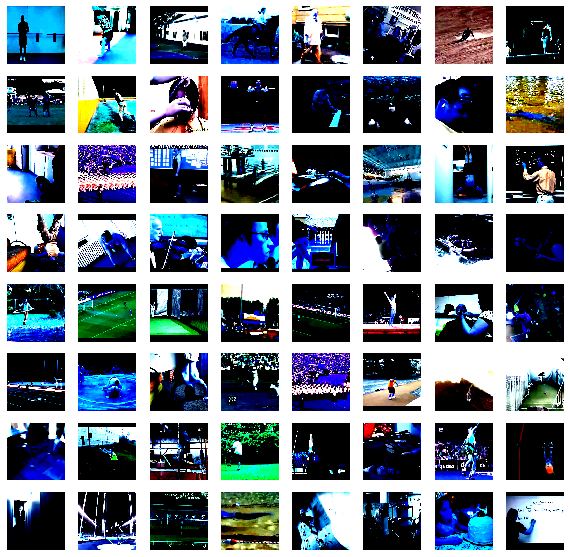

In [11]:
sb = BatchShower(train_dl)
sb.showBatch(3, scale=255)

## Now we create the test dataset and dataloader

In [12]:
# Define test set
test_ds = SingleFrameDataset(
    dataset_path=opt['dataset-path'],
    training=False,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)

test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

Number of validation files: 3783


We can see what it contains. Note that in this case, there is no randomness so most likely all frames will be from the same video.

[['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BandMarching'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['BaseballPitch'], ['Baseb

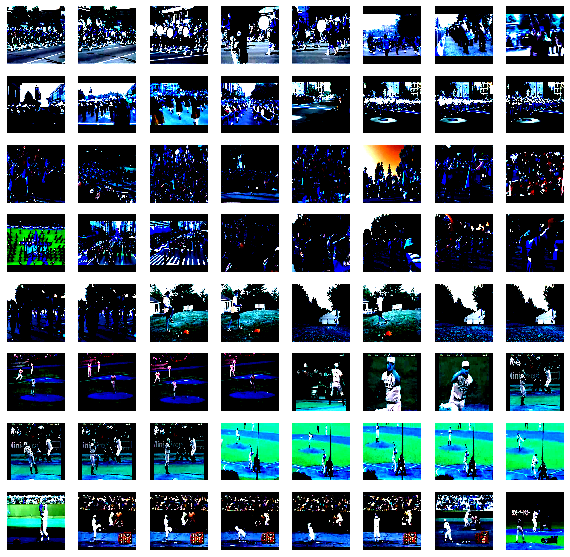

In [22]:
sb = BatchShower(test_dl)
sb.showBatch(3, scale=255)

In [14]:
# Classification criterion
criterion = nn.CrossEntropyLoss().to(device)

# Define network
model = ResNet50Classifier(
    num_classes=train_ds.num_classes,
)
model = model.to(device)

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [23]:
model

ResNet50Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [25]:
model.feature_extractor[7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [26]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.feature_extractor[7][2].parameters():
    param.requires_grad_(True)
for param in model.final.parameters():
    param.requires_grad_(True)

In [27]:
params = []
for param in model.feature_extractor[7][2].parameters():
    params.append(param)
for param in model.final.parameters():
    params.append(param)

In [28]:
optimizer = torch.optim.Adam(params, lr=opt['learning-rate'])

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [29]:
if opt['checkpoint-model']:
    print(f"Loading checkpoint model: opt['checkpoint-model']")
    model.load_state_dict(torch.load(opt['checkpoint-model']))

## Training

We have now everything we need to build the training loop. This is done in the next two functions, the first one is to test the model on the validation set and the second one is the actual training loop.

In [30]:
def test_model(epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [], "acc": []}
        
    for batch_i, (X, y) in enumerate(tqdm(test_dl, 'Test', leave=False)):
        image = Variable(X.to(device), requires_grad=False)
        labels = Variable(y, requires_grad=False).to(device)

        labels = labels.squeeze()
        if len(labels.size()) == 0:
            labels = torch.tensor([labels]).to(device)
        
        with torch.no_grad():
            # Get sequence predictions
            preds = model(image)
                    
        # Compute metrics
        acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
        loss = criterion(preds, labels).item()
        
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        
        # Log test performance
        sys.stdout.write(
            "\rTesting -- [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
            % (
                batch_i,
                len(test_dl),
                loss,
                np.mean(test_metrics["loss"]),
                acc,
                np.mean(test_metrics["acc"]),
            )
        )    
    print("")

In [31]:
def train_model(model, opt, train_dl, test_dl):

    for epoch in tqdm(range(opt['num-epochs']), desc='Epoch #'):
        epoch_metrics = {"loss": [], "acc": []}
        prev_time = time.time()

        #print(f"--- Epoch {epoch} ---")
        for batch_i, (X, y) in enumerate(tqdm(train_dl, 'Train', leave=False)):
            model.train()

            if X.size(0) == 1:
                continue

            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            
            labels = labels.squeeze()
            if len(labels.size()) == 0:
                labels = torch.tensor([labels]).to(device)

            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                # Get sequence predictions
                preds = model(image_sequences)

                # Compute metrics                
                loss = criterion(preds, labels)
                acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()

                loss.backward()
                optimizer.step()

            # Keep track of epoch metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            # Determine approximate time left
            batches_done = epoch * len(train_dl) + batch_i
            batches_left = opt['num-epochs'] * len(train_dl) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] ETA: %s"
                % (
                    epoch,
                    opt['num-epochs'],
                    batch_i,
                    len(train_dl),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    time_left,
                )
            )

#             Empty cache
#                 if torch.cuda.is_available():
#                     torch.cuda.empty_cache()

        # Evaluate the model on the test set
        test_model(epoch)

        model.train()
        
        # Save model checkpoint
        if epoch % opt['checkpoint_interval'] == 0:
            os.makedirs('model-checkpoints', exist_ok=True)
            torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}.pth")
            
    # Print log
    print("-------------------------------------------------------")
    sys.stdout.write(
        "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] ETA: %s"
        % (
            epoch+1,
            opt['num-epochs'],
            batch_i,
            len(train_dl),
            loss.item(),
            np.mean(epoch_metrics["loss"]),
            acc,
            np.mean(epoch_metrics["acc"]),
            time_left,
        )
    )
    
    # save last model
    os.makedirs('model-checkpoints', exist_ok=True)
    random_int = int(np.random.uniform(0,1e14))
    torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")
    print(f"Model saved as: model-checkpoints/{model.__class__.__name__}_{epoch}_{random_int}.pth")

In [32]:
train_model(model, opt, train_dl, test_dl)

[Epoch 0/20] [Batch 148/150] [Loss: 2.177004 (3.276147), Acc: 62.50% (37.31%)] ETA: 0:50:03.407513


Testing -- [Batch 59/60] [Loss: 3.592200 (2.367768), Acc: 14.29% (53.62%)]


[Epoch 1/20] [Batch 148/150] [Loss: 1.074614 (1.607820), Acc: 81.25% (71.49%)] ETA: 0:18:17.331898


Testing -- [Batch 59/60] [Loss: 3.080531 (1.690036), Acc: 14.29% (62.01%)]


[Epoch 2/20] [Batch 148/150] [Loss: 0.698696 (1.002060), Acc: 89.06% (82.15%)] ETA: 0:10:55.832891


Testing -- [Batch 59/60] [Loss: 2.076160 (1.413976), Acc: 71.43% (67.05%)]


[Epoch 3/20] [Batch 148/150] [Loss: 0.722633 (0.679718), Acc: 85.94% (87.98%)] ETA: 0:10:14.785538


Testing -- [Batch 59/60] [Loss: 2.661333 (1.329661), Acc: 14.29% (66.44%)]


[Epoch 4/20] [Batch 148/150] [Loss: 0.361622 (0.489113), Acc: 95.31% (91.17%)] ETA: 0:09:37.096262


Testing -- [Batch 59/60] [Loss: 2.036674 (1.241359), Acc: 28.57% (67.43%)]


[Epoch 5/20] [Batch 148/150] [Loss: 0.306894 (0.377161), Acc: 96.88% (93.41%)] ETA: 0:08:55.881945


Testing -- [Batch 59/60] [Loss: 2.319944 (1.228257), Acc: 28.57% (67.40%)]


[Epoch 6/20] [Batch 148/150] [Loss: 0.329009 (0.293912), Acc: 95.31% (94.68%)] ETA: 0:08:17.0570142


Testing -- [Batch 59/60] [Loss: 2.656033 (1.229449), Acc: 14.29% (66.70%)]


[Epoch 7/20] [Batch 148/150] [Loss: 0.144478 (0.241975), Acc: 100.00% (95.94%)] ETA: 0:07:44.716466


Testing -- [Batch 59/60] [Loss: 1.986303 (1.186599), Acc: 28.57% (68.08%)]


[Epoch 8/20] [Batch 148/150] [Loss: 0.186182 (0.194616), Acc: 96.88% (96.60%)] ETA: 0:07:03.4792393


Testing -- [Batch 59/60] [Loss: 2.118156 (1.178464), Acc: 28.57% (68.29%)]


[Epoch 9/20] [Batch 148/150] [Loss: 0.180694 (0.164918), Acc: 96.88% (97.03%)] ETA: 0:06:25.6311402


Testing -- [Batch 59/60] [Loss: 2.601451 (1.180802), Acc: 14.29% (68.34%)]


[Epoch 10/20] [Batch 148/150] [Loss: 0.093793 (0.155330), Acc: 98.44% (97.11%)] ETA: 0:05:48.1850382


Testing -- [Batch 59/60] [Loss: 1.979752 (1.208825), Acc: 42.86% (66.94%)]


[Epoch 11/20] [Batch 148/150] [Loss: 0.065987 (0.126970), Acc: 98.44% (97.82%)] ETA: 0:05:08.2949524


Testing -- [Batch 59/60] [Loss: 2.491074 (1.214561), Acc: 28.57% (67.61%)]


[Epoch 12/20] [Batch 148/150] [Loss: 0.087665 (0.113021), Acc: 100.00% (97.92%)] ETA: 0:04:29.438205


Testing -- [Batch 59/60] [Loss: 2.506704 (1.196192), Acc: 14.29% (68.60%)]]


[Epoch 13/20] [Batch 148/150] [Loss: 0.094718 (0.111639), Acc: 98.44% (97.80%)] ETA: 0:03:53.1116065


Testing -- [Batch 59/60] [Loss: 2.122203 (1.205052), Acc: 28.57% (67.87%)]


[Epoch 14/20] [Batch 148/150] [Loss: 0.042372 (0.089540), Acc: 100.00% (98.52%)] ETA: 0:03:12.532291


Testing -- [Batch 59/60] [Loss: 2.507708 (1.176462), Acc: 28.57% (68.73%)]


[Epoch 15/20] [Batch 148/150] [Loss: 0.143412 (0.083650), Acc: 95.31% (98.36%)] ETA: 0:02:34.5400261


Testing -- [Batch 59/60] [Loss: 2.238472 (1.184962), Acc: 14.29% (68.68%)]


[Epoch 16/20] [Batch 148/150] [Loss: 0.148157 (0.080074), Acc: 96.88% (98.36%)] ETA: 0:01:55.0000149


Testing -- [Batch 59/60] [Loss: 1.891405 (1.180672), Acc: 28.57% (68.68%)]


[Epoch 17/20] [Batch 148/150] [Loss: 0.020296 (0.074303), Acc: 100.00% (98.55%)] ETA: 0:01:17.161672


Testing -- [Batch 59/60] [Loss: 2.182670 (1.185164), Acc: 28.57% (68.81%)]


[Epoch 18/20] [Batch 148/150] [Loss: 0.075247 (0.066331), Acc: 100.00% (98.83%)] ETA: 0:00:38.924292


Testing -- [Batch 59/60] [Loss: 1.989361 (1.192388), Acc: 42.86% (69.39%)]


[Epoch 19/20] [Batch 148/150] [Loss: 0.052908 (0.066992), Acc: 98.44% (98.70%)] ETA: 0:00:00.5114311


Testing -- [Batch 59/60] [Loss: 2.499676 (1.196699), Acc: 14.29% (68.68%)]

-------------------------------------------------------
[Epoch 20/20] [Batch 149/150] [Loss: 0.052908 (0.066992), Acc: 98.44% (98.70%)] ETA: 0:00:00.511431Model saved as: model-checkpoints/ResNet50Classifier_19_73702927285203.pth


In [ ]:
from nbdev.export import *
notebook2script()